## 3. Modeling
📒 `3.0-rc-modeling.ipynb`

**Objetivo:** Desenvolver, treinar modelo de regressão afim de estimar o preço de veículos com base em suas especificações técnicas e características de mercado.

⚙️ **Atividades:**
- Seleção das variáveis preditoras mais relevantes para o modelo.
- Tratamento de dados faltantes e codificação de variáveis categóricas.
- Definição das métricas de avaliação apropriadas (e.g., RMSE, MAE, R²).
- Implementação de diversos algoritmos de regressão (e.g., Linear Regression, Random Forest, Gradient Boosting).
- Ajuste de hiperparâmetros utilizando técnicas como Grid Search ou Random Search.
- Validação dos modelos por meio de técnicas de cross-validation.
- Comparação de desempenho entre os modelos desenvolvidos.
- Seleção do modelo final baseado nos resultados das métricas de avaliação.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [3]:
file_path = "../data/processed/car_price_prep.csv"
df = pd.read_csv(file_path)

df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,wheel-base,length,...,stroke,compression-ratio,horsepower,peak-rpm,price,price-binned,risk_insurance,car-profile,avg-mpg,power-to-weight-ratio
0,3,115,alfa-romero,gas,std,two,convertible,rwd,88.6,168.8,...,2.68,9.0,111,5000,13495,medium,high,sport/premium,24.0,43.563579
1,3,115,alfa-romero,gas,std,two,convertible,rwd,88.6,168.8,...,2.68,9.0,111,5000,16500,medium,high,sport/premium,24.0,43.563579
2,1,115,alfa-romero,gas,std,two,hatchback,rwd,94.5,171.2,...,3.47,9.0,154,5000,16500,medium,moderate,utility,22.5,54.551895
3,2,164,audi,gas,std,four,sedan,fwd,99.8,176.6,...,3.40,10.0,102,5500,13950,medium,high,utility,27.0,43.645700
4,2,164,audi,gas,std,four,sedan,4wd,99.4,176.6,...,3.40,8.0,115,5500,17450,medium,high,utility,20.0,40.722380


### 3.1 Data Pre-Processing

In [4]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.to_list()

# Define categorical and numerical columns
categorical_features = df.select_dtypes(include=['object']).columns.to_list()

In [5]:
# Seleciona as variáveis preditoras com forte correlação r >= 0.70
numeric_feature_corr_list = ['curb-weight','width', 'length', 'engine-size','wheel-base','horsepower', 'avg-mpg', 'price']

df[numeric_feature_corr_list].corr()

,curb-weight,width,length,engine-size,wheel-base,horsepower,avg-mpg,price
curb-weight,1.000000,0.839017,0.863530,0.840254,0.773156,0.720534,-0.748454,0.832958
width,0.839017,1.000000,0.809871,0.714808,0.768832,0.636875,-0.619881,0.752808
length,0.863530,0.809871,1.000000,0.673289,0.859164,0.521753,-0.658810,0.724854
engine-size,0.840254,0.714808,0.673289,1.000000,0.556308,0.765012,-0.620833,0.724202
wheel-base,0.773156,0.768832,0.859164,0.556308,1.000000,0.343418,-0.486233,0.667160
horsepower,0.720534,0.636875,0.521753,0.765012,0.343418,1.000000,-0.768343,0.639391
avg-mpg,-0.748454,-0.619881,-0.658810,-0.620833,-0.486233,-0.768343,1.000000,-0.665720
price,0.832958,0.752808,0.724854,0.724202,0.667160,0.639391,-0.665720,1.000000


De acordo com a tabela acima, foi verificado a correlação das variáveis significativas com a variável alvo `price`.

- Examinando os pares das correlações das variáveis vimos que caracteristicas relacionadas ao **tamanho do veículo** , como `length`, `width` e `curb-weight` estão correlacionadas, desta forma, selecinamos a variável `curb-weight` que é mais correlacionada com a variável alvo (corr = 0.8329);
- Da mesma forma, foi verificado as correlações das variáveis referente á **performance do veículo**, vimos que `horsepower`, `engine-size`, estão correlacionadas, desta forma, selecinamos a variável `engine-size` que é mais correlacionada com a variável alvo (corr = 0.724202);

In [6]:
df = df[['curb-weight','engine-size', 'price']]
df.head()

,curb-weight,engine-size,price
0,2548,130,13495
1,2548,130,16500
2,2823,152,16500
3,2337,109,13950
4,2824,136,17450


Para ajudar na seleção de características preditivas que não sejam redundantes, considere a seguinte matriz de dispersão, que mostra os gráficos de dispersão para cada par de características de entrada. A diagonal da matriz mostra o histograma de cada característica.

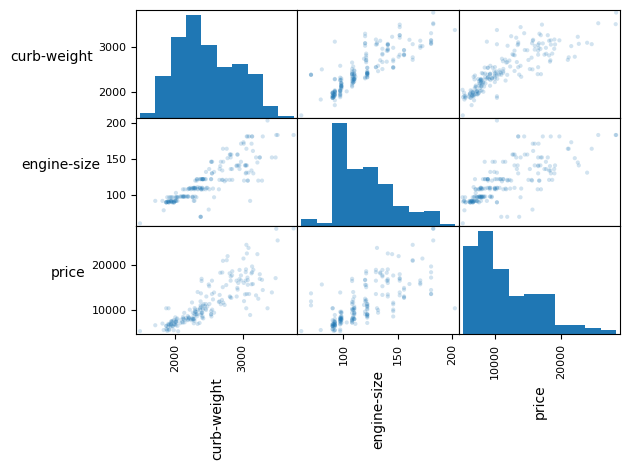

In [7]:
axes = pd.plotting.scatter_matrix(df, alpha=0.2)
# need to rotate axis labels so we can read them
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

Como você pode ver, a relação entre as variáveis `curb-weight`, `engine-size` vs `price` é linear, porém a amostra pequena.

#### Extract the input features and labels from the data set
- Extract the required columns and convert the resulting dataframes to NumPy arrays.

In [8]:
X = df.iloc[:,[0,1]].to_numpy()
y = df.iloc[:,[2]].to_numpy()

#### Preprocess selected features
Padronizar seus recursos de entrada para que o modelo não favoreça inadvertidamente nenhum recurso devido à sua magnitude da escala de valores.Aplicar somente no dataset de treinamento e teste separadamente.

In [9]:
std_scaler = preprocessing.StandardScaler()
X_std = std_scaler.fit_transform(X)

In [10]:
X_std[0:5]

array([[ 0.14131878,  0.40659064],
       [ 0.14131878,  0.40659064],
       [ 0.75497362,  1.20945429],
       [-0.32952184, -0.35977922],
       [ 0.75720509,  0.62555345]])

In [11]:
pd.DataFrame(X_std).describe().round(2)

,0,1
count,191.00,191.00
mean,-0.00,-0.00
std,1.00,1.00
min,-2.22,-2.11
25%,-0.80,-0.80
50%,-0.20,-0.32
75%,0.77,0.63
max,2.82,3.07


Como você pode ver, uma variável padronizada tem média zero e desvio padrão de um.

### 3.2 Dataset de Treinamento e Teste
Divida seus dados aleatoriamente em conjuntos de treinamento e teste, usando 80% do conjunto de dados para treinamento e reservando os 20% restantes para testes.


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

##### Construção Modelos de regressão linear múltipla

In [13]:
#create a model object
regressor = linear_model.LinearRegression()

#train the model in the training data
regressor.fit(X_train, y_train)

# print the coefficients
coef_ = regressor.coef_
intercept_ = regressor.intercept_

print ('Coefficients: ',coef_)
print ('Intercept: ',intercept_)

Coefficients:  [[4092.31264422  248.91841095]]
Intercept:  [11667.31987651]


Os parâmetros Coeficientes e Intercepto definem o hiperplano mais adequado aos dados. Como existem apenas duas variáveis, portanto dois parâmetros, o hiperplano é um plano. Você pode transformar os parâmetros do seu modelo de volta ao espaço original antes da padronização da seguinte maneira. Isso lhe dará uma noção precisa do que eles significam em termos dos seus recursos de entrada originais. Sem esses ajustes, as saídas do modelo ficariam vinculadas a um espaço abstrato e transformado que não se alinha com as variáveis ​​independentes reais e com o problema do mundo real que você está resolvendo.



In [16]:
# Obtendo os parâmetros de padronização (media e desvio padrão) do scaler
means_ = std_scaler.mean_ # media
std_devs_ = np.sqrt(std_scaler.var_) # raiz quadrada da variância

# Os parâmetros de mínimos quadrados podem ser calculados em relação ao espaço de recursos original, não padronizado, como:
coef_original = coef_ / std_devs_
intercept_original = intercept_ - np.sum(coef_ * means_ / std_devs_)

print('Coeficientes Originais: ',coef_original)
print('Intercept Original: ',intercept_original)

Coefficients:  [[9.13188162 9.08397933]]
Intercept:  [-12102.10328882]


##### Visualize model outputs

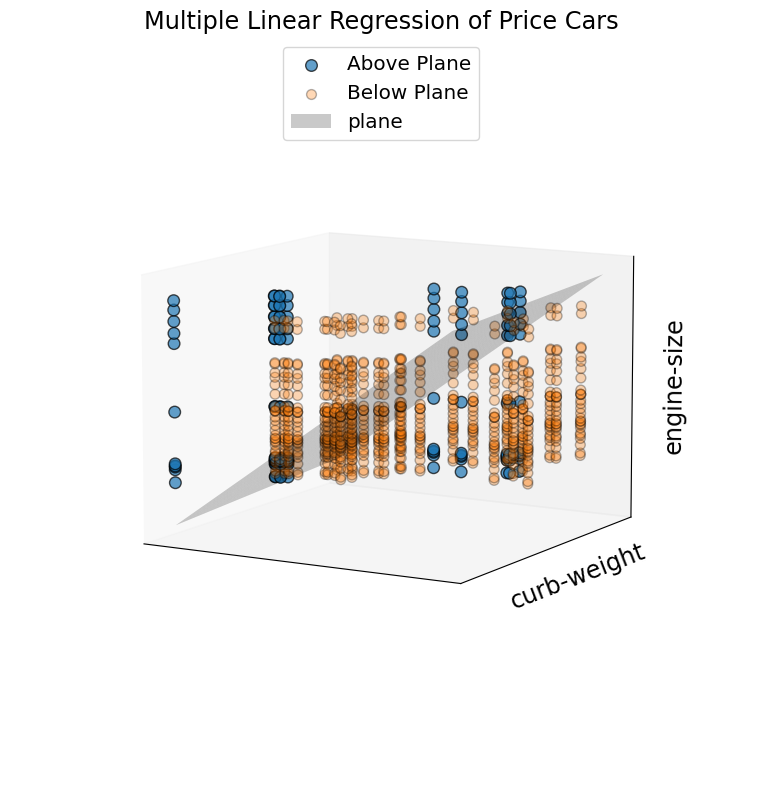

In [17]:
# Ensure X1, X2, and y_test have compatible shapes for 3D plotting
X1 = X_test[:, 0] if X_test.ndim > 1 else X_test
X2 = X_test[:, 1] if X_test.ndim > 1 else np.zeros_like(X1)

# Create a mesh grid for plotting the regression plane
x1_surf, x2_surf = np.meshgrid(np.linspace(X1.min(), X1.max(), 100),
                               np.linspace(X2.min(), X2.max(), 100))

y_surf = intercept_ +  coef_[0,0] * x1_surf  +  coef_[0,1] * x2_surf

# Predict y values using trained regression model to compare with actual y_test for above/below plane colors
y_pred = regressor.predict(X_test.reshape(-1, 1)) if X_test.ndim == 1 else regressor.predict(X_test)
above_plane = y_test >= y_pred
below_plane = y_test < y_pred
above_plane = above_plane[:,0]
below_plane = below_plane[:,0]

# Plotting
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points above and below the plane in different colors
ax.scatter(X1[above_plane], X2[above_plane], y_test[above_plane],  label="Above Plane",s=70,alpha=.7,ec='k')
ax.scatter(X1[below_plane], X2[below_plane], y_test[below_plane],  label="Below Plane",s=50,alpha=.3,ec='k')

# Plot the regression plane
ax.plot_surface(x1_surf, x2_surf, y_surf, color='k', alpha=0.21,label='plane')

# Set view and labels
ax.view_init(elev=10)

ax.legend(fontsize='x-large',loc='upper center')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.75)
ax.set_xlabel('', fontsize='xx-large')
ax.set_ylabel('curb-weight', fontsize='xx-large')
ax.set_zlabel('engine-size', fontsize='xx-large')
ax.set_title('Multiple Linear Regression of Price Cars', fontsize='xx-large')
plt.tight_layout()
plt.show()


Em vez de fazer um gráfico 3D, que é difícil de interpretar, podemos observar fatias verticais do gráfico 3D plotando cada variável separadamente como uma linha de melhor ajuste usando os parâmetros de regressão correspondentes.

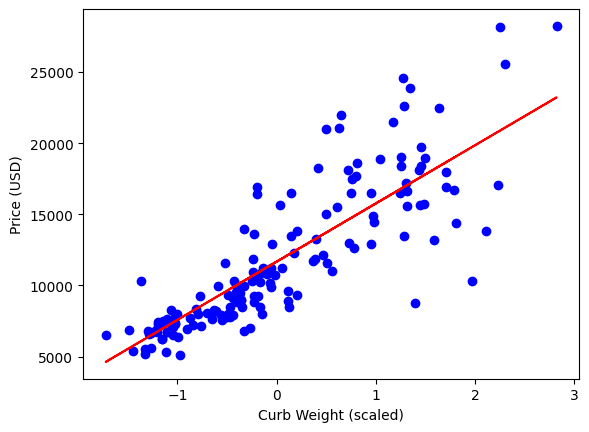

In [24]:
plt.scatter(X_train[:,0], y_train, color='blue')
plt.plot(X_train[:,0], intercept_[0] + coef_[0,0] * X_train[:,0],  color='red')
plt.xlabel('Curb Weight (scaled)')
plt.ylabel('Price (USD)')
plt.show()

**Insights:** 
- A variável `curb-weight` está fornecendo boa explicação da variação no preço. Existe uma relação linear positiva clara entre `curb-weight` e `price`. À medida que o peso do carro aumenta, o preço também tende a aumentar.
- A linha vermelha (reta de regressão) acompanha bem a nuvem de pontos. Isso sugere que `curb-weight` é um bom preditor linear para `price`.
- O peso do carro influencia diretamente o preço, possivelmente porque carros maiores e mais pesados geralmente possuem mais equipamentos, motorização superior e acabamentos melhores.

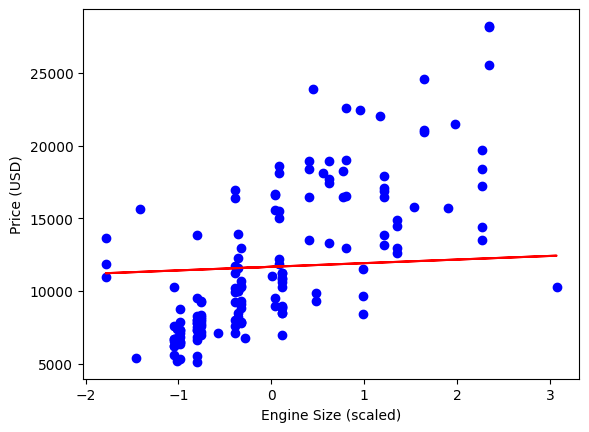

In [25]:
plt.scatter(X_train[:,1], y_train, color='blue')
plt.plot(X_train[:,1], intercept_ + coef_[0,1] * X_train[:,1], color='red')
plt.xlabel('Engine Size (scaled)')
plt.ylabel('Price (USD)')
plt.show()

**Insights:**
- `engine-size`, apesar de ser importante individualmente, dentro do modelo múltiplo parece ter pouco efeito adicional. Isso sugere que há redundância ou sobreposição de informação entre essas variáveis (elas podem estar correlacionadas entre si).
- O modelo praticamente gera uma reta quase horizontal (coeficiente pequeno).
- A reta não acompanha bem a nuvem de pontos — indica baixa capacidade preditiva isolada dessa variável.
- Embora `engine-size` também se correlacione com `price`, o seu efeito isolado é fraco quando comparado com `curb-weight`.
Provavelmente existe efeito de multicolinearidade com curb-weight (outras variáveis técnicas estão relacionadas).

#### ⚠ Possíveis Problemas Identificados
**Multicolinearidade:** Provável alta correlação entre `curb-weight` e `engine-size`. Isso pode estar fazendo o coeficiente de `engine-size` perder importância no modelo múltiplo.

#### Checkando a multicolinearidade
- Calcular o VIF (Variance Inflation Factor):

Interpetração VIF:

- VIF < 5 → Sem indício preocupante de multicolinearidade
- VIF ≥ 5 → Atenção
- VIF ≥ 10 → Multicolinearidade alta e problemática
- Se VIF > 5 ou 10 → há multicolinearidade relevante.

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = X_std  # suas features padronizadas
vif_data = pd.DataFrame()
vif_data["feature"] = ['curb-weight', 'engine-size']
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(vif_data)


       feature       VIF
0  curb-weight  3.401669
1  engine-size  3.401669


 **Conclusão:**
 - Valor de VIF encontrado para ambas as variáveis (~3.4) indica que não há multicolinearidade severa.
- Existe alguma correlação entre` curb-weight` e `engine-size` (o que é natural — motores maiores geralmente precisam de carros maiores), mas o nível de redundância não é suficiente para preocupar o modelo.

Sendo assim, a inclusão das duas variáveis ainda pode ser válida, embora o engine-size sozinho esteja contribuindo pouco, como já vimos no gráfico anterior.

##### a) Determine e imprima os parâmetros para a linha de regressão linear de melhor ajuste para o preço em relação ao peso do carro (´curb-weight´)

Coeficientes:  [[4300.8597692]]
Intercepto:  [11663.47230237]


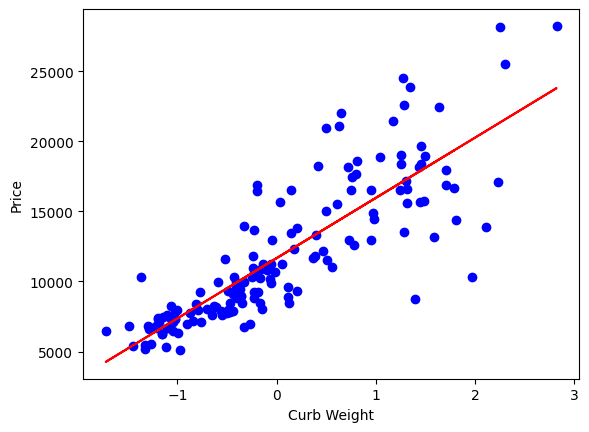

In [ ]:
X_train_1 = X_train[:,0]

regressor_1 = linear_model.LinearRegression()
regressor_1.fit(X_train_1.reshape(-1, 1), y_train)

coef_1 = regressor_1.coef_
intercept_1 = regressor_1.intercept_

print("Coeficientes: ", coef_1)
print("Intercepto: ", intercept_1)

plt.scatter(X_train_1, y_train,  color='blue')
plt.plot(X_train_1, coef_1[0] * X_train_1 + intercept_1, color='red')
plt.xlabel("Curb Weight")
plt.ylabel("Price")
plt.show()

Gere o mesmo gráfico de dispersão e a linha de regressão de melhor ajuste, mas agora baseie o resultado no conjunto de dados de teste. Considere como o resultado do teste se compara ao resultado do treinamento.

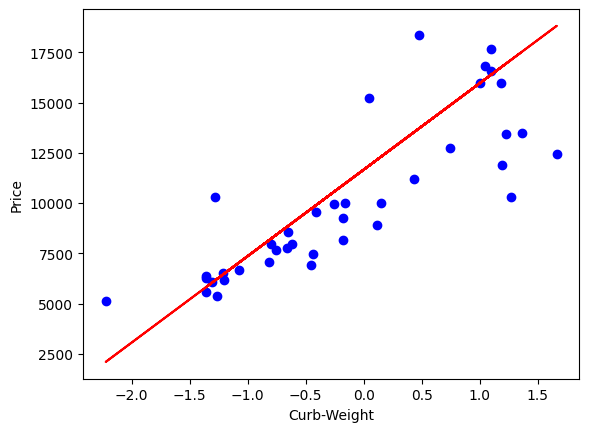

In [32]:
X_test_1 = X_test[:,0]
plt.scatter(X_test_1, y_test,  color='blue')
plt.plot(X_test_1, coef_1[0] * X_test_1 + intercept_1, color='red')
plt.xlabel("Curb-Weight")
plt.ylabel("Price")
plt.show()

Repitir para a variável `engine-size` como variável independente. 

Coeficientes:  [[3639.48269367]]
Intercepto:  [11768.461916]


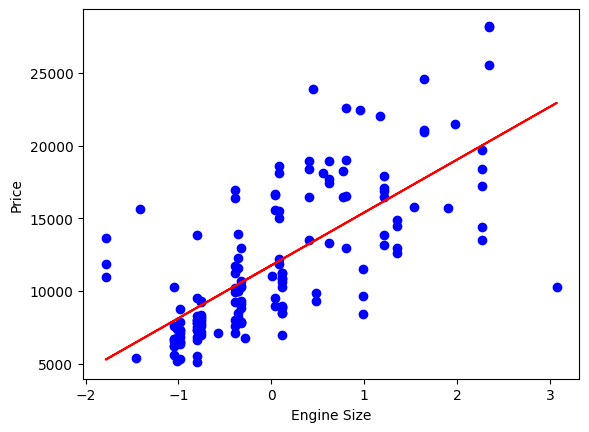

In [33]:
X_train_2 = X_train[:,1]

regressor_2 = linear_model.LinearRegression()
regressor_2.fit(X_train_2.reshape(-1, 1), y_train)

coef_2 = regressor_2.coef_
intercept_2 = regressor_2.intercept_

print("Coeficientes: ", coef_2)
print("Intercepto: ", intercept_2)

plt.scatter(X_train_2, y_train,  color='blue')
plt.plot(X_train_2, coef_2[0] * X_train_2 + intercept_2, color='red')
plt.xlabel("Engine Size")
plt.ylabel("Price")
plt.show()